# CV ASSIGNMENT 1
## Siya Puttagunta
## 2021101062

Imports

In [1]:
import cv2
import numpy as np
import os
import glob
from scipy import linalg
import matplotlib.pyplot as plt

## Q1

### 1

Harris Corners

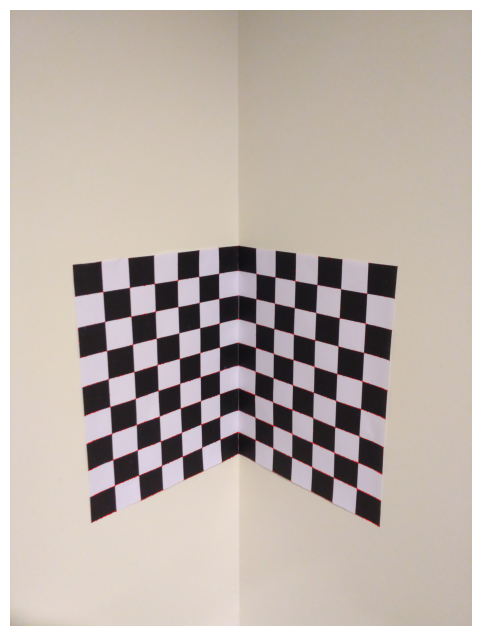

In [2]:
img = cv2.imread('calib-object.jpg')

gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
gray = np.float32(gray)

dst = cv2.cornerHarris(gray, blockSize=2, ksize=3, k=0.04)
dst = cv2.dilate(dst,None)

img[dst > 0.01 * dst.max()] = [0,0,255]

cv2.imwrite('result1_1.jpg', img)

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,8))
plt.imshow(img)
plt.axis('off')
plt.show()

FindChessboardCorners

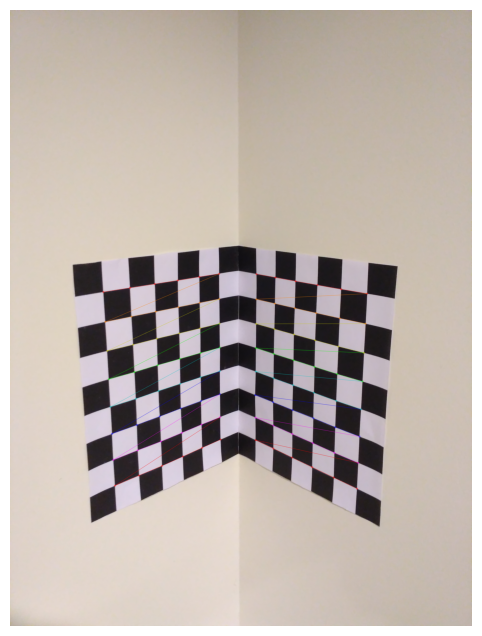

In [3]:
def get_3d_points(x):
    CHECKERBOARD = (6, 8)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    
    imgpoints = [] 
    
    gray = cv2.cvtColor(x,cv2.COLOR_BGR2GRAY)

    ret, corners = cv2.findChessboardCorners(gray, CHECKERBOARD, cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_FAST_CHECK + cv2.CALIB_CB_NORMALIZE_IMAGE)
        
    if ret == True:
        corners2 = cv2.cornerSubPix(gray, corners, (11,11),(-1,-1), criteria)  
        imgpoints.append(corners2)

        img = cv2.drawChessboardCorners(x, CHECKERBOARD, corners2, ret)

img = cv2.imread('calib-object.jpg')
h,w = img.shape[:2]

get_3d_points(img[:, :w//2])
get_3d_points(img[:, w//2:])

cv2.imwrite('result1_2.jpg', img)

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,8))
plt.imshow(img)
plt.axis('off')
plt.show()

### 2

In [4]:
objpoints_list = np.zeros((3 * 3, 3), np.float32) 
imgpoints_list = np.zeros((3 * 3, 2), np.float32) 

objpoints_list[0] = [6*2, 0, 0]
objpoints_list[1] = [0, 6*2, 0]
objpoints_list[2] = [0, 0, 0]
objpoints_list[3] = [6*2, 0, 4*2]
objpoints_list[4] = [0, 6*2, 4*2]
objpoints_list[5] = [0, 0, 4*2]
objpoints_list[6] = [6*2, 0, 7*2]
objpoints_list[7] = [0, 6*2, 7*2]
objpoints_list[8] = [0, 0, 7*2]

imgpoints_list[0] = [710, 3213]
imgpoints_list[1] = [2343,3232]
imgpoints_list[2] = [1542,2852]
imgpoints_list[3] = [668,2493]
imgpoints_list[4] = [2380,2508]
imgpoints_list[5] = [1540,2246]
imgpoints_list[6] = [630,1904]
imgpoints_list[7] = [2412,1916]
imgpoints_list[8] = [1544,1762]

objpoints_list = np.array(objpoints_list)
imgpoints_list = np.array(imgpoints_list)

print(objpoints_list)

[[12.  0.  0.]
 [ 0. 12.  0.]
 [ 0.  0.  0.]
 [12.  0.  8.]
 [ 0. 12.  8.]
 [ 0.  0.  8.]
 [12.  0. 14.]
 [ 0. 12. 14.]
 [ 0.  0. 14.]]


In [5]:
def calc(P):
    M = P[:, 0:3]
    MC = -1 * P[:, 3]

    C = np.dot(np.linalg.inv(M), MC)
    K, R = linalg.rq(M)
    
    K /= K[2, 2]

    if K[0, 0] < 0:
        S = np.diag([-1, 1, 1])
        K = np.dot(K, S)
        R = np.dot(S, R)

    if K[1, 1] < 0:
        S = np.diag([1, -1, 1])
        K = np.dot(K, S)
        R = np.dot(S, R)

    return K, R, C

def DLT(image_points, world_points):
    A = np.zeros((image_points.shape[0]*2, 12))
    i = 0
    
    for j, k in zip(image_points, world_points):
        u, v = j
        x, y, z = k
        
        A[i] = [-x, -y, -z, -1, 0, 0, 0, 0, u*x, u*y, u*z, u]
        A[i+1] = [0, 0, 0, 0, -x, -y, -z, -1, v*x, v*y, v*z, v]

        i += 2

    U, D, V = np.linalg.svd(A)
    P = V[-1]
    P = P.reshape(3, 4)

    return P

projection_matrix = DLT(imgpoints_list, objpoints_list)
K, R, C = calc(projection_matrix)

print("Intrinsic matrix K")
print(K)
print("Rotation matrix R")
print(R)
print("Translation vector C")
print(C)
print("Projection matrix P")
print(projection_matrix)

Intrinsic matrix K
[[3.69323956e+03 1.09126603e+01 1.58094637e+03]
 [0.00000000e+00 3.67712396e+03 1.98678853e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Rotation matrix R
[[-0.71739822  0.69665293  0.00380731]
 [ 0.15589474  0.16585874 -0.97374931]
 [-0.67899678 -0.69797248 -0.22759129]]
Translation vector C
[29.59056763 31.09272693 21.29567568]
Projection matrix P
[[-2.45919275e-02  9.72275623e-03 -2.35508652e-03  4.75535248e-01]
 [-5.12670258e-03 -5.13371965e-03 -2.66504159e-02  8.78861996e-01]
 [-4.48712290e-06 -4.61252304e-06 -1.50402787e-06  3.08221723e-04]]


### 3

In [6]:
ext_coords = np.array([[7*2, 0, 8*2, 1], [0, 0, 8*2, 1], [0, 7*2, 8*2, 1], [0, 7*2, -1*2, 1], [0, 0, -1*2, 1], [7*2, 0, -1*2, 1]])
P = projection_matrix

img_coords = []
for point in ext_coords:
    img_coord = np.dot(P, point)
    img_coord = img_coord / img_coord[2]
    img_coords.append(img_coord[:2])

print(img_coords)

[array([ 422.73385767, 1719.91374891]), array([1540.88562922, 1592.27082752]), array([2613.93270483, 1733.21741519]), array([2498.89671168, 3487.83787535]), array([1543.0574281, 2995.0952417]), array([ 547.31453884, 3463.58355894])]


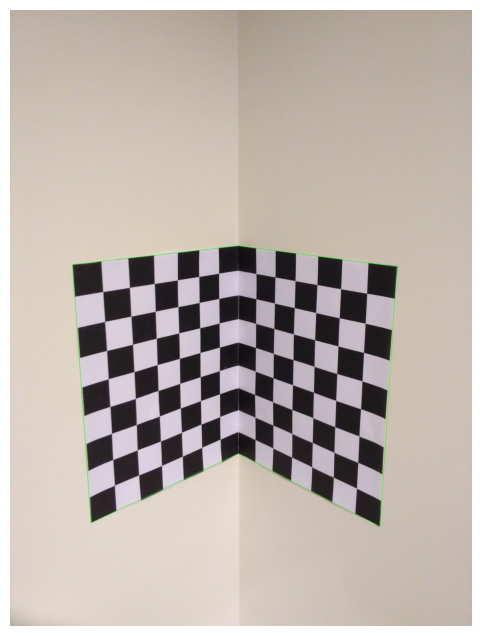

In [7]:
img = cv2.imread('calib-object.jpg')

img = cv2.line(img, (int(img_coords[0][0]), int(img_coords[0][1])), (int(img_coords[1][0]), int(img_coords[1][1])), (0, 255, 0), 2)
img = cv2.line(img, (int(img_coords[1][0]), int(img_coords[1][1])), (int(img_coords[2][0]), int(img_coords[2][1])), (0, 255, 0), 2)
img = cv2.line(img, (int(img_coords[2][0]), int(img_coords[2][1])), (int(img_coords[3][0]), int(img_coords[3][1])), (0, 255, 0), 2)
img = cv2.line(img, (int(img_coords[3][0]), int(img_coords[3][1])), (int(img_coords[4][0]), int(img_coords[4][1])), (0, 255, 0), 2)
img = cv2.line(img, (int(img_coords[4][0]), int(img_coords[4][1])), (int(img_coords[5][0]), int(img_coords[5][1])), (0, 255, 0), 2)
img = cv2.line(img, (int(img_coords[5][0]), int(img_coords[5][1])), (int(img_coords[0][0]), int(img_coords[0][1])), (0, 255, 0), 2)

cv2.imwrite('result1_3.jpg', img)

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,8))
plt.imshow(img)
plt.axis('off')
plt.show()

### 4

In [8]:
def compute_rotation_angles(R):
    theta_x = np.arctan2(R[2, 1], R[2, 2])
    theta_y = np.arctan2(-R[2, 0], np.sqrt(R[0, 0]**2 + R[1, 0]**2))
    theta_z = np.arctan2(R[1, 0], R[0, 0])
    
    return np.array([theta_x, theta_y, theta_z])

print("Angles in radians")
print(compute_rotation_angles(R))

angles = compute_rotation_angles(R) * 180 / np.pi
print("Angles in degrees")
print(angles)

pan = angles[0]
tilt = angles[1]
roll = angles[2]

print("Pan: ", pan) 
print("Tilt: ", tilt) 
print("Roll: ", roll) 

Angles in radians
[-1.88600011  0.74639525  2.92761369]
Angles in degrees
[-108.05984623   42.76529747  167.73990868]
Pan:  -108.05984622964709
Tilt:  42.765297469154284
Roll:  167.73990867808948


## Q2

### 1

Estimate of the intrinsic matrix

In [9]:
wc = [np.array([
    [6*2, 0, 0],
    [6*2, 4*2, 0],
    [6*2, 7*2, 0],
    [1*2, 2*2, 0],
    [2*2, 1*2, 0],
    [0, 0, 0],
    [3*2, 5*2, 0],
    [4*2, 6*2, 0],
], dtype=np.float32)]

ic = [np.array([
    [710, 3213],
    [668, 2493],
    [630, 1904],
    [1418, 2596], 
    [1292, 2801],
    [1542, 2852],
    [1144, 2184], 
    [985,2037],
], dtype=np.float32)]

img = cv2.imread('calib-object.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(wc, ic, gray.shape[::-1], None, None)
print("Camera Matrix: ", mtx)

Camera Matrix:  [[3.38596256e+03 0.00000000e+00 1.45700651e+03]
 [0.00000000e+00 3.39714663e+03 2.09667254e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


In [10]:
objpoints_list = np.zeros((1, 3 * 3, 3), np.float32) 
imgpoints_list = np.zeros((1, 3 * 3, 2), np.float32) 

objpoints_list[0][0] = [6*2, 0, 0]
objpoints_list[0][1] = [0, 6*2, 0]
objpoints_list[0][2] = [0, 0, 0]
objpoints_list[0][3] = [6*2, 0, 4*2]
objpoints_list[0][4] = [0, 6*2, 4*2]
objpoints_list[0][5] = [0, 0, 4*2]
objpoints_list[0][6] = [6*2, 0, 7*2]
objpoints_list[0][7] = [0, 6*2, 7*2]
objpoints_list[0][8] = [0, 0, 7*2]

imgpoints_list[0][0] = [710, 3213]
imgpoints_list[0][1] = [2343,3232]
imgpoints_list[0][2] = [1542,2852]
imgpoints_list[0][3] = [668,2493]
imgpoints_list[0][4] = [2380,2508]
imgpoints_list[0][5] = [1540,2246]
imgpoints_list[0][6] = [630,1904]
imgpoints_list[0][7] = [2412,1916]
imgpoints_list[0][8] = [1544,1762]

init_mtx = mtx

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints_list, imgpoints_list, gray.shape[::-1], init_mtx, np.zeros(4), flags=(cv2.CALIB_USE_INTRINSIC_GUESS))
rotation_matrix, _ = cv2.Rodrigues(np.array(rvecs))
 
print("Camera matrix : ")
print(mtx)
print("dist : ")
print(dist)
print("rvecs : ")
print(rvecs)
print("tvecs : ")
print(tvecs)
print("rotation_matrix : ")
print(rotation_matrix)

Camera matrix : 
[[3.75618531e+03 0.00000000e+00 1.64572553e+03]
 [0.00000000e+00 3.74355368e+03 2.03341740e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
dist : 
[[ 4.73440396e-01]
 [-4.11386275e+00]
 [-6.43401203e-03]
 [ 1.13091566e-02]
 [ 1.29524933e+01]]
rvecs : 
(array([[ 0.82082065],
       [ 1.99574436],
       [-1.55519102]]),)
tvecs : 
(array([[-1.3306849 ],
       [10.37084207],
       [47.88998581]]),)
rotation_matrix : 
[[-0.70662184  0.7075543   0.0072448 ]
 [ 0.16588143  0.17559881 -0.9703857 ]
 [-0.68787275 -0.68449396 -0.24145207]]


Projection Matrix

In [11]:
K = mtx
R = rotation_matrix
t = tvecs[0]

mat_A = np.dot(K, R)
mat_B = np.dot(K, t)
mat_B = mat_B.reshape(3, 1)

P = np.hstack((mat_A, mat_B))
print(P)

[[-3.78625234e+03  1.53121587e+03 -3.70151025e+02  7.38154733e+04]
 [-7.77746392e+02 -7.34498359e+02 -4.12366381e+03  1.36204135e+05]
 [-6.87872751e-01 -6.84493956e-01 -2.41452071e-01  4.78899858e+01]]


In [12]:
ext_coords = np.array([[7*2, 0, 8*2, 1], [0, 0, 8*2, 1], [0, 7*2, 8*2, 1], [0, 7*2, -1*2, 1], [0, 0, -1*2, 1], [7*2, 0, -1*2, 1]])
img_coords = []

for point in ext_coords:
    img_coord = np.dot(P, point)
    img_coord = img_coord / img_coord[2]
    img_coords.append(img_coord[:2])

print(img_coords)

[array([ 432.76232729, 1725.08845907]), array([1542.08640814, 1595.06457639]), array([2593.49962528, 1740.29786769]), array([2474.68060108, 3458.84437089]), array([1541.27188666, 2986.20699171]), array([ 556.18886955, 3447.43941835])]


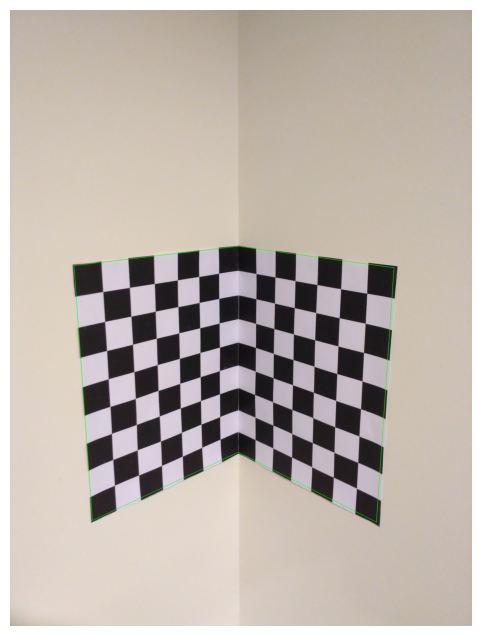

In [13]:
img = cv2.imread('calib-object.jpg')

img = cv2.line(img, (int(img_coords[0][0]), int(img_coords[0][1])), (int(img_coords[1][0]), int(img_coords[1][1])), (0, 255, 0), 2)
img = cv2.line(img, (int(img_coords[1][0]), int(img_coords[1][1])), (int(img_coords[2][0]), int(img_coords[2][1])), (0, 255, 0), 2)
img = cv2.line(img, (int(img_coords[2][0]), int(img_coords[2][1])), (int(img_coords[3][0]), int(img_coords[3][1])), (0, 255, 0), 2)
img = cv2.line(img, (int(img_coords[3][0]), int(img_coords[3][1])), (int(img_coords[4][0]), int(img_coords[4][1])), (0, 255, 0), 2)
img = cv2.line(img, (int(img_coords[4][0]), int(img_coords[4][1])), (int(img_coords[5][0]), int(img_coords[5][1])), (0, 255, 0), 2)
img = cv2.line(img, (int(img_coords[5][0]), int(img_coords[5][1])), (int(img_coords[0][0]), int(img_coords[0][1])), (0, 255, 0), 2)

cv2.imwrite('result2_1.jpg', img)

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,8))
plt.imshow(img)
plt.axis('off')
plt.show()

### 2

In [14]:
CHECKERBOARD = (5, 5)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
 
objpoints = []
imgpoints = [] 
 
objp = np.zeros((1, CHECKERBOARD[0] * CHECKERBOARD[1], 3), np.float32)
objp[0,:,:2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)
objp = objp * 2

img = cv2.imread('assign1.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

ret, corners = cv2.findChessboardCorners(gray, CHECKERBOARD, cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_FAST_CHECK + cv2.CALIB_CB_NORMALIZE_IMAGE)
     
if ret == True:
    objpoints.append(objp)

    corners2 = cv2.cornerSubPix(gray, corners, (11,11),(-1,-1), criteria)   
    imgpoints.append(corners2)
 
    img = cv2.drawChessboardCorners(img, CHECKERBOARD, corners2, ret)
     
cv2.imwrite('result2_2.jpg', img)
 
h,w = img.shape[:2]

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
rotation_matrix, _ = cv2.Rodrigues(np.array(rvecs))
 
print("Camera matrix :")
print(mtx)
print("dist :")
print(dist)
print("rvecs :")
print(rvecs)
print("tvecs :")
print(tvecs)
print("rotation_matrix :")
print(rotation_matrix)

Camera matrix :
[[3.05864402e+03 0.00000000e+00 1.08139658e+03]
 [0.00000000e+00 1.87025193e+03 1.03974466e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
dist :
[[ 8.09823433e-02 -1.51853769e+01  2.45645816e-02  4.02192618e-03
   4.34443122e+02]]
rvecs :
(array([[-0.88344962],
       [-0.03053448],
       [ 0.00433905]]),)
tvecs :
(array([[-4.36024673],
       [-7.27248126],
       [62.02419704]]),)
rotation_matrix :
[[ 0.99955458  0.00883647 -0.02850527]
 [ 0.01642768  0.63450914  0.77274076]
 [ 0.02491516 -0.77286485  0.63408135]]


Projection Matrix

In [15]:
K = mtx
R = rotation_matrix  

mat_A = np.dot(K, R)
t = tvecs[0]
mat_B = np.dot(K, t)

P = np.hstack((mat_A, mat_B))
print(P)

[[ 3.08422481e+03 -8.08745790e+02  5.98505927e+02  5.37363120e+04]
 [ 5.66293064e+01  3.83109840e+02  2.10450261e+03  5.08879558e+04]
 [ 2.49151555e-02 -7.72864846e-01  6.34081355e-01  6.20241970e+01]]


In [16]:
ext_coords = np.array([[-1*2, -1*2, 0, 1], [5*2, -1*2, 0, 1], [-1*2, 5*2, 0, 1], [5*2, 5*2, 0, 1]])
img_coords = []

for point in ext_coords:
    img_coord = np.dot(P, point)
    img_coord = img_coord / img_coord[2]
    img_coords.append(img_coord[:2])

print(img_coords)

[array([774.32744523, 787.28591919]), array([1350.63141063,  794.24571044]), array([ 727.80683457, 1006.63789379]), array([1402.35627047, 1013.57871847])]


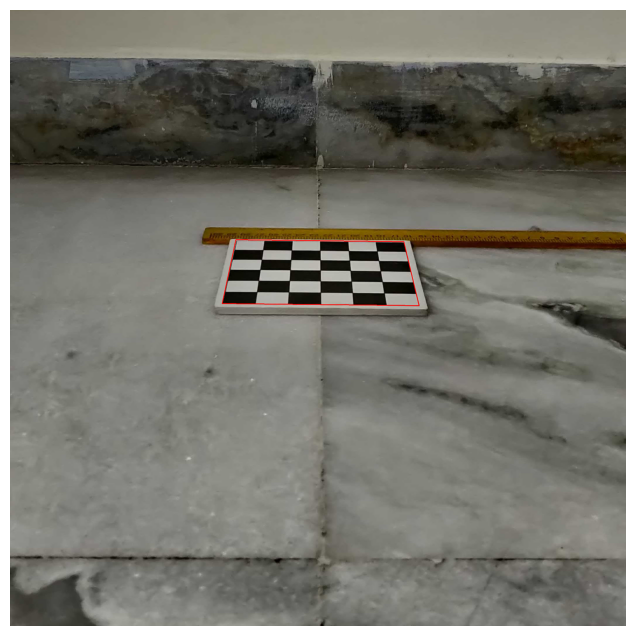

In [17]:
img = cv2.imread('assign1.jpg')

cv2.line(img, (int(img_coords[0][0]), int(img_coords[0][1])), (int(img_coords[1][0]), int(img_coords[1][1])), (0, 0, 255), 2)
cv2.line(img, (int(img_coords[1][0]), int(img_coords[1][1])), (int(img_coords[3][0]), int(img_coords[3][1])), (0, 0, 255), 2)
cv2.line(img, (int(img_coords[3][0]), int(img_coords[3][1])), (int(img_coords[2][0]), int(img_coords[2][1])), (0, 0, 255), 2)
cv2.line(img, (int(img_coords[2][0]), int(img_coords[2][1])), (int(img_coords[0][0]), int(img_coords[0][1])), (0, 0, 255), 2)

cv2.imwrite('result2_3.jpg', img)

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,8))
plt.imshow(img)
plt.axis('off')
plt.show()

### 3

Homogenised Image of World Origin

In [18]:
A = np.array([0, 0, 0, 1])
world_origin_image = np.dot(P, A.T)
world_origin_image = world_origin_image / world_origin_image[2]

print(world_origin_image)

[866.37658514 820.45327824   1.        ]


## Q3

### 1

In [19]:
ext_coords = np.array([[8, -1*2, 0, 1], [20, -1*2, 0, 1], [8, 5*2, 0, 1], [20, 5*2, 0, 1]])
img_coords_new = []

for point in ext_coords:
    img_coord = np.dot(P, point)
    img_coord = img_coord / img_coord[2]
    img_coords_new.append(img_coord[:2])

print(img_coords_new)

[array([1254.95602735,  793.09027731]), array([1826.77592537,  799.99591629]), array([1290.44537324, 1012.42720328]), array([1958.85755558, 1019.30487825])]


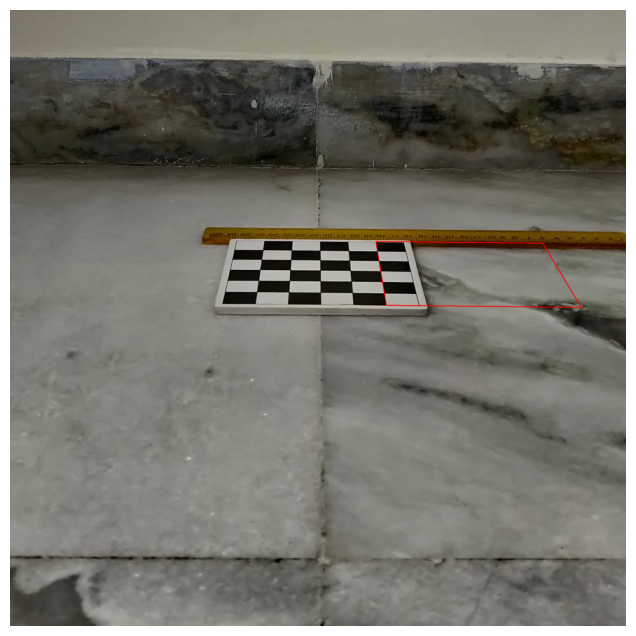

In [20]:
img = cv2.imread('assign1.jpg')

cv2.line(img, (int(img_coords_new[0][0]), int(img_coords_new[0][1])), (int(img_coords_new[1][0]), int(img_coords_new[1][1])), (0, 0, 255), 2)
cv2.line(img, (int(img_coords_new[1][0]), int(img_coords_new[1][1])), (int(img_coords_new[3][0]), int(img_coords_new[3][1])), (0, 0, 255), 2)
cv2.line(img, (int(img_coords_new[3][0]), int(img_coords_new[3][1])), (int(img_coords_new[2][0]), int(img_coords_new[2][1])), (0, 0, 255), 2)
cv2.line(img, (int(img_coords_new[2][0]), int(img_coords_new[2][1])), (int(img_coords_new[0][0]), int(img_coords_new[0][1])), (0, 0, 255), 2)

cv2.imwrite('result3_1.jpg', img)

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,8))
plt.imshow(img)
plt.axis('off')
plt.show()

### 2

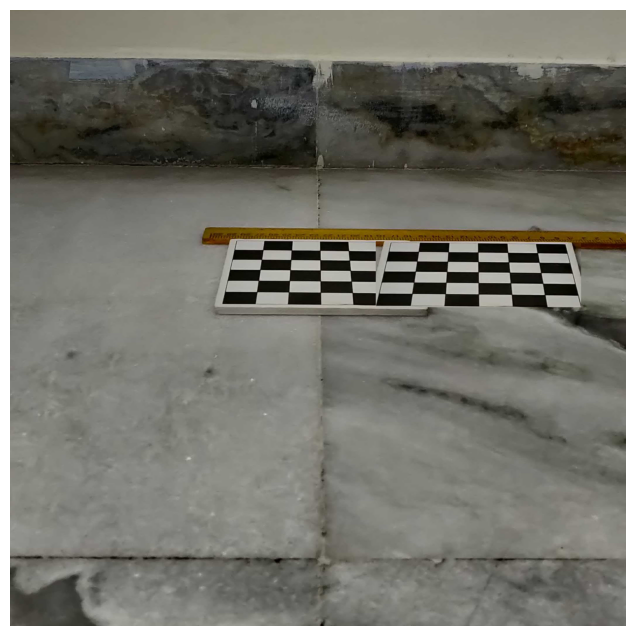

In [21]:
src_ext_coords = img_coords
dest_ext_coords = img_coords_new

src_ext_coords = np.array(src_ext_coords, dtype=np.float32)
dest_ext_coords = np.array(dest_ext_coords, dtype=np.float32)

src_ext_coords = src_ext_coords.astype(int)
dest_ext_coords = dest_ext_coords.astype(int)

x_min, y_min = np.min(src_ext_coords, axis=0)[:2]
x_max, y_max = np.max(src_ext_coords, axis=0)[:2]

dest_x_min, dest_y_min = np.min(dest_ext_coords, axis=0)[:2]
dest_x_max, dest_y_max = np.max(dest_ext_coords, axis=0)[:2]

img = cv2.imread('assign1.jpg')

subimage = img[y_min:y_max, x_min:x_max]
destimage = img[dest_y_min:dest_y_max, dest_x_min:dest_x_max]

subimage = cv2.resize(subimage, (dest_x_max - dest_x_min, dest_y_max - dest_y_min))
img[dest_y_min:dest_y_max, dest_x_min:dest_x_max] = subimage

cv2.imwrite('result3_2.jpg', img)

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,8))
plt.imshow(img)
plt.axis('off')
plt.show()